# Checking in on how the 96 member control run is tracking

In [1]:
import glob
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [10]:
path = '/g/data/xv83/ds0092/CAFE/historical/WIP/c5-d60-pX-hist-19601101-96mem'
ensembles = 96

# Ocean scalar

In [29]:
variable = 'temp_total'

ds = []
for mem in range(1, ensembles+1):
    files = sorted(glob.glob(f'{path}/mem{str(mem).zfill(3)}/ocean_scalar*.nc'))[:-3]
    ds.append(xr.open_mfdataset(files)[variable].assign_coords({'ensemble': mem}))
ds = xr.concat(ds, dim='ensemble').compute()

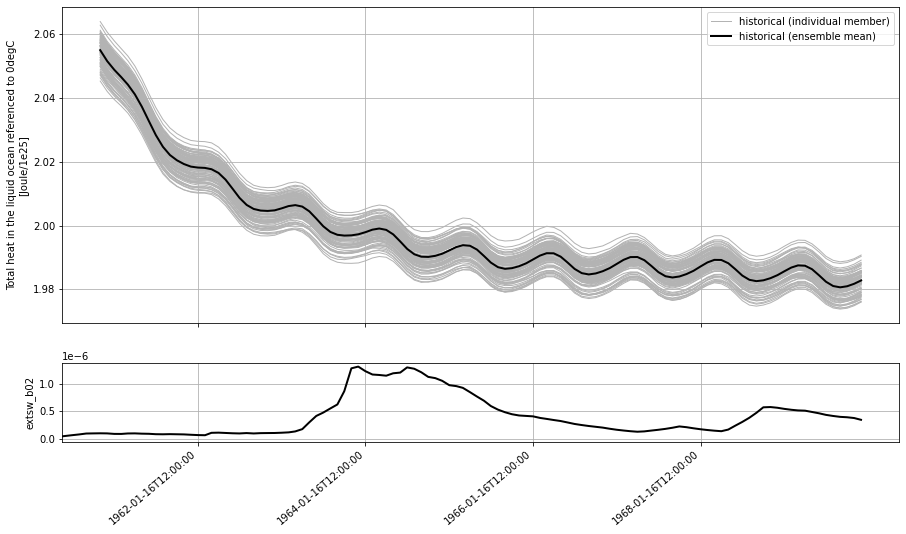

In [36]:
fig, (ax0, ax1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [4, 1]}, figsize=(15,8))

for idx, e in enumerate(ds.ensemble.values):
    ax0.plot([np.datetime64(t.strftime()) for t in ds.time.values], 
         ds.sel(ensemble=e), 
         label='historical (individual member)' if idx == 0 else '__nolabel__', 
         color=[0.7,0.7,0.7], linewidth=1)
ax0.plot([np.datetime64(t.strftime()) for t in ds.time.values], 
         ds.mean('ensemble'), 
         label='historical (ensemble mean)', color='k', linewidth=2)

ax0.legend(ncol=1)
ax0.set_ylabel(f'{ds.attrs["long_name"]}\n[{ds.attrs["units"]}]');
ax0.grid()
xticks = [np.datetime64(t.strftime()) for t in ds.time.values[2+12::24]]
ax0.set_xticks(xticks)
ax0.set_xticklabels([])
xlims = ax0.get_xlim()

f = xr.open_dataset(
    f'/g/data/xv83/ds0092/CAFE/historical/WIP/c5-d60-pX-hist-19601101-96mem/mem001/INPUT/extsw_data.nc')

period = slice(str(ds.time[0].dt.year.values), 
               str(ds.time[-1].dt.year.values))
lev = 60

lat_mean = f['extsw_b02'].sel(time=period).mean('lat')
ax1.plot([np.datetime64(t.strftime()) for t in lat_mean.time.values],
        lat_mean.sel(pfull=lev, method='nearest'), color='k', linewidth=2)
ax1.set_xticks(xticks)
ax1.set_xticklabels(xticks, rotation=40, ha='right');
ax1.set_ylabel('extsw_b02');
ax1.grid()
ax1.set_xlim(xlims);